### 1. Imports

In [1]:
!pip install torchgeo --quiet
!pip install optuna --quiet
!pip install optuna-integration[pytorch_lightning] --quiet

In [2]:
import os
import torch
import rasterio
import numpy as np
import random
import time
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from rasterio.warp import reproject, Resampling
from collections import defaultdict

import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW  
from torch.optim.lr_scheduler import ReduceLROnPlateau  
from torch.utils.data import Dataset, Subset, DataLoader, WeightedRandomSampler
from torchvision import transforms 
from torchmetrics.classification import MulticlassF1Score

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor
from pytorch_lightning.loggers import CSVLogger
from torchgeo.models import resnet50, ResNet50_Weights

import optuna
from optuna.integration import PyTorchLightningPruningCallback

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

### 2. Utility functions

In [3]:
# Set seeds once
seed = 42

os.environ['PYTHONHASHSEED']= str(seed)

torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
pl.seed_everything(seed, workers=True)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)


Seed set to 42


In [4]:
class S2Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, bands, class_idx=None, labeled=True, transform=None, target_size=264):
        self.root_dir = root_dir
        self.bands = bands
        self.labeled = labeled
        self.transform = transform
        self.class_idx = class_idx if class_idx is not None else {}
        self.samples = []
        self.target_size = target_size

        # all samples
        if labeled:
            for cls_name, label in self.class_idx.items():
                cls_dir = os.path.join(root_dir, cls_name)
                if not os.path.exists(cls_dir):
                    continue
                for img_id in sorted(os.listdir(cls_dir)):
                    img_dir = os.path.join(cls_dir, img_id)
                    if os.path.isdir(img_dir):
                        self.samples.append((img_dir, label))
        else:
            for img_id in sorted(os.listdir(root_dir)):
                img_dir = os.path.join(root_dir, img_id)
                if os.path.isdir(img_dir):
                    self.samples.append((img_dir, None))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_dir, label = self.samples[idx]
        bands_data = []
        H = W = self.target_size
        for band in self.bands:
            band_path = os.path.join(img_dir, f"{band}.tif")
            if os.path.exists(band_path):
                with rasterio.open(band_path) as src:
                    arr = src.read(1, out_shape=(H, W), 
                                   resampling=Resampling.bilinear).astype(np.float32)
            else:
                arr = np.zeros((H, W), dtype=np.float32)
            bands_data.append(torch.from_numpy(arr))

        # B10 as zeros
        if "B10" not in self.bands:
            bands_data.insert(10, torch.zeros((H, W), dtype=torch.float32))

        img = torch.stack(bands_data, dim=0)
        if self.transform:
            img = self.transform(img)
        if self.labeled:
            return img, label
        else:
            img_id = os.path.basename(img_dir)  
            return img, img_id

In [5]:
# MEAN AND STD FROM DATA
def calculate_stats(dataset):
    # Stack all images into a single tensor of shape (N, 13, H, W)
    all_images = torch.stack([img for img, _ in dataset])
    # Compute mean and std per band (across N, H, W)
    mean = all_images.mean(dim=(0, 2, 3)) # Shape: (13,)
    std = all_images.std(dim=(0, 2, 3)) # Shape: (13,)
    return mean, std

# SPLIT DATA
def stratified_split(dataset, val_ratio=0.2, seed=42):
    random.seed(seed)
    class_indices = defaultdict(list)
    for i, (_, label) in enumerate(dataset.samples):
        class_indices[label].append(i)
    train_idx, val_idx = [], []
    for label, indices in class_indices.items():
        random.shuffle(indices)
        n_val = max(1, int(len(indices) * val_ratio))
        val_idx.extend(indices[:n_val])
        train_idx.extend(indices[n_val:])
    return Subset(dataset, train_idx), Subset(dataset, val_idx)

Prep data for model

In [6]:
# root directory
input_path = '/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2026p2/ICPR02/kaggle'

# bands in order
bands = ["B1", "B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A", "B9", "B11", "B12"] #missing B10

# classes
class_idx = {"Aphid": 0, "Blast": 1, "RPH": 2, "Rust": 3}

In [7]:
# load dataset
dataset = S2Dataset(root_dir=input_path, bands=bands, class_idx=class_idx, labeled=True, transform=None)

# sanity check
print(dataset.__len__())
img, label = dataset.__getitem__(0)
print(f"Shape: {img.shape}, Label: {label}")

900
Shape: torch.Size([13, 264, 264]), Label: 0


In [8]:
# mean, std = calculate_stats(dataset)
# print(mean, std)

In [9]:
#mean = [2358.7412, 2402.7629, 2580.9255, 2614.2227, 3057.6877, 3578.1008,
        #3796.8345, 3795.6868, 3947.5913, 4833.6362, 0.0000, 3379.1743,
       #2666.4465]
#std = [2994.4861, 2847.0354, 2542.9307, 2411.1196, 2399.0249, 2137.6804,
        #2036.8357, 2042.7140, 1957.9615, 3559.4121, 0.0000, 1535.7960,
        #1393.8278]

mean =[1278.6852, 1434.4397, 1694.8578, 1932.4095, 2269.2026, 2789.2571,
       3019.3687, 3144.4609, 3180.2004, 3289.7437,    0.0000, 2666.2808,
       2098.4189]
        
std= [2148.8049, 2148.8838, 2038.1532, 2097.1721, 2066.5100, 1890.2559,
      1842.6375, 1898.1923, 1762.8573, 1992.9287,    0.0001, 1247.9540,
      1132.2416]

# to avoid 0 std
std = [max(s, 1e-5) for s in std]   

# define transform with augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=mean, std=std)
])

# Validation transforms (no augmentation)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=mean, std=std)
])

In [10]:
# apply transform
# dataset = S2Dataset(root_dir=input_path, bands=bands, class_idx=class_idx, labeled=True, transform=transform)

# split data
train_dataset, val_dataset = stratified_split(dataset, val_ratio=0.2)

# apply transform
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

In [11]:
# Weighted sampler + loss weights 
def weighted_sampler(dataset_subset, num_classes):
    """
    Creates WeightedRandomSampler based on class frequencies in the subset.    
    Args:
        dataset_subset: Subset or Dataset with .samples attribute
        num_classes: int 
    Returns:
        WeightedRandomSampler ready for DataLoader
    """
    # Get labels from the subset
    labels = [dataset_subset.dataset.samples[i][1] for i in dataset_subset.indices]
    labels_tensor = torch.tensor(labels)   
    # Count occurrences per class
    class_counts = torch.bincount(labels_tensor, minlength=num_classes).float()
    print("Class counts in train split:", class_counts.tolist()) 
    # Inverse frequency weights
    weights = 1.0 / (class_counts + 1e-8)           # avoid division by zero
    weights = weights / weights.sum()                # normalize
    # Assign weight to each sample
    sample_weights = [weights[label].item() for label in labels]
    g = torch.Generator()
    g.manual_seed(seed)
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True,
        generator = g
    )
    return sampler

In [12]:
# Create sampler for train
num_classes = len(class_idx)
train_sampler = weighted_sampler(train_dataset, num_classes=num_classes)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, sampler=train_sampler,
                          num_workers=4,pin_memory=True,
                         worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id))
val_loader = DataLoader(val_dataset,batch_size=16,shuffle=False,num_workers=4,pin_memory=True,
                       worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id))

# Loss weights (for Focal loss) 
labels = torch.tensor([label for _, label in dataset.samples]) #collect all labels
class_counts = torch.bincount(labels, minlength=num_classes).float() #num of images per class
class_counts_for_loss = class_counts  
alpha = 1.0 / (class_counts_for_loss + 1e-8) #compute raw inverse frequency, used 1e-8 to avoid division by 0
alpha = alpha / alpha.sum() * num_classes   # normalize so average ~1
print("Loss/Focal alpha weights:", alpha.tolist())

Class counts in train split: [232.0, 60.0, 396.0, 32.0]
Loss/Focal alpha weights: [0.31489798426628113, 1.2176055908203125, 0.18448570370674133, 2.283010482788086]


### 3. MoCo model with resnet50 backbone

In [13]:
def load_moco_encoder(
    checkpoint_path=None,
    architecture="resnet50",
    verbose=True
):
    if architecture != "resnet50":
        raise NotImplementedError("Only resnet50 supported")

    # torchgeo weights
    if checkpoint_path is None:
        if verbose:
            print("Loading TorchGeo Sentinel-2 MoCo weights")
        backbone = resnet50(weights=ResNet50_Weights.SENTINEL2_ALL_MOCO)

    # Custom checkpoint
    else:
        if verbose:
            print(f"Loading custom MoCo checkpoint: {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location="cpu")

        # Some checkpoints store inside "state_dict"
        if "state_dict" in checkpoint:
            checkpoint = checkpoint["state_dict"]

        # Clean prefixes
        cleaned = {}
        for k, v in checkpoint.items():
            new_key = k
            for prefix in ["module.","encoder_q.", "encoder.","momentum_encoder.","backbone.",]:
                if new_key.startswith(prefix):
                    new_key = new_key[len(prefix):]
                    break
            cleaned[new_key] = v

        # Auto-detect input channel (resnet architecture default is 3)
        if "conv1.weight" not in cleaned:
            raise ValueError("conv1.weight not found in checkpoint")
        in_channels = cleaned["conv1.weight"].shape[1]
        if verbose:
            print(f"Detected input channels: {in_channels}")

        # architecture to match input checkpoint
        backbone = resnet50(weights=None)
        backbone.conv1 = nn.Conv2d(
            in_channels,
            64, #out_channels
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )

        # load weights
        missing, unexpected = backbone.load_state_dict(cleaned, strict=False)
        if verbose:
            print(f"Missing keys: {len(missing)}")
            print(f"Unexpected keys: {len(unexpected)}")

    # remove classification head
    if hasattr(backbone, "fc"):
        backbone.fc = nn.Identity()
    elif hasattr(backbone, "head"):
        backbone.head = nn.Identity()

    return backbone

In [14]:
# Downstream Classifier
class MoCoClassifier(pl.LightningModule):
    def __init__(
        self,
        encoder=None,                      # optional: pre-loaded encoder
        custom_checkpoint_path=None,       # alternative: load from path
        num_classes=4,
        lr=3e-3,
        freeze_backbone=True,
        focal_gamma=2.0,
        focal_alpha=None,
        label_smoothing=0.1,
        weight_decay=1e-5,
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["encoder", "focal_alpha"])

        # Load or use encoder
        if encoder is not None:
            self.encoder = encoder
            print("Using provided encoder")
        elif custom_checkpoint_path is not None:
            self.encoder = load_moco_encoder(checkpoint_path=custom_checkpoint_path)
        else:
            self.encoder = load_moco_encoder()  # defaults to TorchGeo

        # Feature dimension
        in_features = 2048
        self.classifier = nn.Linear(in_features, num_classes)

        # Freeze backbone for linear probe
        if freeze_backbone:
            for p in self.encoder.parameters():
                p.requires_grad = False

        # Focal loss parameters
        self.focal_gamma = focal_gamma
        self.focal_alpha = focal_alpha
        self.label_smoothing = label_smoothing

        #train 
        self.train_f1_macro = MulticlassF1Score(num_classes=num_classes, average="macro")
        
        # Validation metrics
        self.val_f1_macro = MulticlassF1Score(num_classes=num_classes, average="macro")
        self.val_f1_weighted = MulticlassF1Score(num_classes=num_classes, average="weighted")

    def forward(self, x):
        features = self.encoder(x)
        return self.classifier(features)

    def focal_loss(self, logits, targets):
        ce_loss = F.cross_entropy(
            logits,
            targets,
            reduction="none",
            label_smoothing=self.label_smoothing
        )
        pt = torch.exp(-ce_loss)
        focal_weight = (1 - pt) ** self.focal_gamma
        loss = focal_weight * ce_loss

        if self.focal_alpha is not None:
            alpha = self.focal_alpha.to(logits.device)
            alpha_t = alpha[targets]
            loss = alpha_t * loss

        return loss.mean()

    def _shared_step(self, batch, stage="train"):
        imgs, labels = batch
        logits = self(imgs)
        loss = self.focal_loss(logits, labels)
    
        preds = logits.argmax(dim=1)
        acc = (preds == labels).float().mean()
    
        # Log loss and accuracy
        self.log(f"{stage}_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log(f"{stage}_acc", acc, on_step=False, on_epoch=True, prog_bar=True)
    
        # Update and log F1 scores
        if stage == "train":
            self.train_f1_macro.update(preds, labels)
            self.log("train_f1_macro", self.train_f1_macro.compute(), on_step=False, on_epoch=True, prog_bar=True)
            # self.train_f1_macro.reset()
        elif stage == "val":
            self.val_f1_macro.update(preds, labels)
            self.val_f1_weighted.update(preds, labels)
            self.log("val_f1_macro", self.val_f1_macro.compute(), on_step=False, on_epoch=True, prog_bar=True)
            self.log("val_f1_weighted", self.val_f1_weighted.compute(), on_step=False, on_epoch=True, prog_bar=True)
    
        return loss

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, "train")

    def validation_step(self, batch, batch_idx):
        self._shared_step(batch, "val")

    def on_train_epoch_end(self):
        # Log train F1 scores
        self.log("train_f1_macro", self.train_f1_macro.compute(), prog_bar=True)
        self.train_f1_macro.reset()
    
    def on_validation_epoch_end(self):
        # Log validation F1 scores
        self.log("val_f1_macro", self.val_f1_macro.compute(), prog_bar=True)
        self.log("val_f1_weighted", self.val_f1_weighted.compute(), prog_bar=True)
        self.val_f1_macro.reset()
        self.val_f1_weighted.reset()

    def configure_optimizers(self):
        params = [p for p in self.parameters() if p.requires_grad]
        optimizer = AdamW(params, lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)

        scheduler = ReduceLROnPlateau(
            optimizer,
            mode="max",
            factor=0.5,
            patience=5
        )

        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_f1_macro",
                "interval": "epoch",
                "frequency": 1
            }
        }

In [15]:
def train_model(
    model: pl.LightningModule,
    train_loader,
    val_loader,
    max_epochs: int = 60,
    monitor_metric: str = "val_f1_macro",
    mode: str = "max",
    patience: int = 10,
    checkpoint_dir: str = "/kaggle/working/checkpoints/moco_focal"
):

    checkpoint_cb = ModelCheckpoint(
        dirpath=checkpoint_dir,
        filename="moco-{epoch:03d}-{val_f1_macro:.4f}",
        monitor=monitor_metric,
        mode=mode,
        save_top_k=1,
        save_last=True,
        verbose=False
    )

    early_stop_cb = EarlyStopping(
        monitor=monitor_metric,
        mode=mode,
        patience=patience,
        min_delta=0.005,
        verbose=True
    )

    lr_monitor_cb = LearningRateMonitor(logging_interval="epoch")

    trainer = pl.Trainer(
        max_epochs=max_epochs,
        logger=CSVLogger(save_dir="/kaggle/working/logs/", 
                         name=f"exp_{datetime.now().strftime('%Y%m%d_%H%M%S')}", 
                         version=None),
        accelerator="auto",
        deterministic= True,
        devices=1,
        precision="32",
        callbacks=[checkpoint_cb, early_stop_cb, lr_monitor_cb],
        default_root_dir=checkpoint_dir,
        log_every_n_steps=10,
        enable_progress_bar=True
    )

    start_time = time.time()
    trainer.fit(model, train_loader, val_loader)
    end_time = time.time()
    print(f"\nTotal training time: {(end_time-start_time)/60:.2f} minutes")

    return trainer

### Hyperparameter tuning - optuna
lr, batch size,focal-loss (gamma),weight-decay 

In [16]:
# OPTUNA OBJECTIVE 
def hyperparam_objective(trial, train_dataset, val_dataset, num_classes, alpha): 
    # Define hyperparameters to test
    hyperparams = {
        'lr': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [8, 16, 24]),
        'focal_gamma': trial.suggest_float('focal_gamma', 1.0, 4.0),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True),
        'label_smoothing': trial.suggest_float('label_smoothing', 0.0, 0.2),
    } 
    print(f"Trial {trial.number}: {hyperparams}")
    
    # Create model with trial hyperparameters
    model2 = MoCoClassifier(
        custom_checkpoint_path='/kaggle/input/models/ethelogallo/ssl-full/pytorch/default/1/ssl_backbone_20260215_172951.pth',
        num_classes=num_classes,
        lr=hyperparams['lr'],
        freeze_backbone=True,
        focal_gamma=hyperparams['focal_gamma'],
        focal_alpha=alpha,
        label_smoothing=hyperparams['label_smoothing'],
        weight_decay=hyperparams['weight_decay'],
    )
    
    # Create data loaders with trial batch size
    train_loader2 = DataLoader(
        train_dataset, 
        batch_size=hyperparams['batch_size'], 
        sampler=train_sampler,
        num_workers=4,
        pin_memory=True,
        worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id)
    )
    val_loader2 = DataLoader(
        val_dataset,
        batch_size=hyperparams['batch_size'],
        shuffle=False,
        num_workers=4,
        worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id),
        pin_memory=True
    )
    
    # Using shorter epochs for search and adding pruning callback to stop bad trials early
    pruning_callback = PyTorchLightningPruningCallback(trial, monitor="val_f1_macro")
    
    # Create a modified trainer setup for Optuna
    checkpoint_cb = ModelCheckpoint(
        monitor="val_f1_macro",
        mode="max",
        save_top_k=1,
        filename=f"trial_{trial.number}_best"
    )
    
    early_stop_cb = EarlyStopping(
        monitor="val_f1_macro",
        mode="max",
        patience=8,  # Shorter patience for quick trials
        min_delta=0.005
    )
    
    # trainer with pruning
    trainer2 = pl.Trainer(
        max_epochs=20,  
        deterministic=True,
        accelerator="auto",
        devices=1,
        precision="32",
        callbacks=[checkpoint_cb, early_stop_cb, pruning_callback],
        enable_progress_bar=True,
        logger=False,
    )
    
    # Train and return metric
    trainer2.fit(model2, train_loader2, val_loader2)
    
    return trainer2.callback_metrics["val_f1_macro"].item()

In [17]:
# RUN OPTUNA STUDY
# Create study
study = optuna.create_study(
    direction="maximize",
    study_name="moco_hyperparams",
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5),
    sampler = optuna.samplers.TPESampler(seed= seed)
)

# Run trials 
study.optimize(
    lambda trial: hyperparam_objective(trial, train_dataset, val_dataset, num_classes, alpha),
    n_trials=10,
    show_progress_bar=True
)

# Show results
print("Best hyperparameters:")
print(f"Best F1 Score: {study.best_value:.4f}")
print("\nOptimal parameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

[I 2026-02-16 13:26:05,007] A new study created in memory with name: moco_hyperparams


  0%|          | 0/10 [00:00<?, ?it/s]

Trial 0: {'lr': 0.0001329291894316216, 'batch_size': 8, 'focal_gamma': 1.4680559213273097, 'weight_decay': 2.9375384576328313e-06, 'label_smoothing': 0.011616722433639893}
Loading custom MoCo checkpoint: /kaggle/input/models/ethelogallo/ssl-full/pytorch/default/1/ssl_backbone_20260215_172951.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores


Missing keys: 2
Unexpected keys: 0


/usr/local/lib/python3.12/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:881: Checkpoint directory /kaggle/working/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=20` reached.


[I 2026-02-16 13:30:42,828] Trial 0 finished with value: 0.14822211861610413 and parameters: {'lr': 0.0001329291894316216, 'batch_size': 8, 'focal_gamma': 1.4680559213273097, 'weight_decay': 2.9375384576328313e-06, 'label_smoothing': 0.011616722433639893}. Best is trial 0 with value: 0.14822211861610413.
Trial 1: {'lr': 0.003967605077052989, 'batch_size': 16, 'focal_gamma': 3.909729556485983, 'weight_decay': 0.0003142880890840109, 'label_smoothing': 0.04246782213565523}
Loading custom MoCo checkpoint: /kaggle/input/models/ethelogallo/ssl-full/pytorch/default/1/ssl_backbone_20260215_172951.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=20` reached.


[I 2026-02-16 13:35:19,964] Trial 1 finished with value: 0.22472608089447021 and parameters: {'lr': 0.003967605077052989, 'batch_size': 16, 'focal_gamma': 3.909729556485983, 'weight_decay': 0.0003142880890840109, 'label_smoothing': 0.04246782213565523}. Best is trial 1 with value: 0.22472608089447021.
Trial 2: {'lr': 3.511356313970405e-05, 'batch_size': 24, 'focal_gamma': 2.2958350559263474, 'weight_decay': 7.4763120622522945e-06, 'label_smoothing': 0.1223705789444759}
Loading custom MoCo checkpoint: /kaggle/input/models/ethelogallo/ssl-full/pytorch/default/1/ssl_backbone_20260215_172951.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-16 13:37:25,255] Trial 2 finished with value: 0.057555921375751495 and parameters: {'lr': 3.511356313970405e-05, 'batch_size': 24, 'focal_gamma': 2.2958350559263474, 'weight_decay': 7.4763120622522945e-06, 'label_smoothing': 0.1223705789444759}. Best is trial 1 with value: 0.22472608089447021.
Trial 3: {'lr': 2.621087878265438e-05, 'batch_size': 24, 'focal_gamma': 3.3555278841790406, 'weight_decay': 3.972110727381911e-06, 'label_smoothing': 0.10284688768272232}
Loading custom MoCo checkpoint: /kaggle/input/models/ethelogallo/ssl-full/pytorch/default/1/ssl_backbone_20260215_172951.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-16 13:41:16,308] Trial 3 finished with value: 0.06127672269940376 and parameters: {'lr': 2.621087878265438e-05, 'batch_size': 24, 'focal_gamma': 3.3555278841790406, 'weight_decay': 3.972110727381911e-06, 'label_smoothing': 0.10284688768272232}. Best is trial 1 with value: 0.22472608089447021.
Trial 4: {'lr': 0.0005987474910461401, 'batch_size': 16, 'focal_gamma': 1.1951547789558385, 'weight_decay': 0.0007025166339242157, 'label_smoothing': 0.19312640661491187}
Loading custom MoCo checkpoint: /kaggle/input/models/ethelogallo/ssl-full/pytorch/default/1/ssl_backbone_20260215_172951.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-16 13:45:32,333] Trial 4 finished with value: 0.1619139015674591 and parameters: {'lr': 0.0005987474910461401, 'batch_size': 16, 'focal_gamma': 1.1951547789558385, 'weight_decay': 0.0007025166339242157, 'label_smoothing': 0.19312640661491187}. Best is trial 1 with value: 0.22472608089447021.
Trial 5: {'lr': 0.002661901888489057, 'batch_size': 24, 'focal_gamma': 2.3204574812188037, 'weight_decay': 2.3233503515390116e-06, 'label_smoothing': 0.09903538202225404}
Loading custom MoCo checkpoint: /kaggle/input/models/ethelogallo/ssl-full/pytorch/default/1/ssl_backbone_20260215_172951.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

`Trainer.fit` stopped: `max_epochs=20` reached.


[I 2026-02-16 13:50:15,103] Trial 5 finished with value: 0.240046888589859 and parameters: {'lr': 0.002661901888489057, 'batch_size': 24, 'focal_gamma': 2.3204574812188037, 'weight_decay': 2.3233503515390116e-06, 'label_smoothing': 0.09903538202225404}. Best is trial 5 with value: 0.240046888589859.
Trial 6: {'lr': 1.2681352169084594e-05, 'batch_size': 8, 'focal_gamma': 1.9351332282682328, 'weight_decay': 3.632486956676606e-05, 'label_smoothing': 0.10934205586865593}
Loading custom MoCo checkpoint: /kaggle/input/models/ethelogallo/ssl-full/pytorch/default/1/ssl_backbone_20260215_172951.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-16 13:52:18,148] Trial 6 finished with value: 0.07533539831638336 and parameters: {'lr': 1.2681352169084594e-05, 'batch_size': 8, 'focal_gamma': 1.9351332282682328, 'weight_decay': 3.632486956676606e-05, 'label_smoothing': 0.10934205586865593}. Best is trial 5 with value: 0.240046888589859.
Trial 7: {'lr': 3.585612610345396e-05, 'batch_size': 8, 'focal_gamma': 3.6844820512829464, 'weight_decay': 6.218704727769077e-05, 'label_smoothing': 0.18437484700462337}
Loading custom MoCo checkpoint: /kaggle/input/models/ethelogallo/ssl-full/pytorch/default/1/ssl_backbone_20260215_172951.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-16 13:52:33,239] Trial 7 pruned. Trial was pruned at epoch 0.
Trial 8: {'lr': 1.8427970406864546e-05, 'batch_size': 24, 'focal_gamma': 2.166031869068446, 'weight_decay': 6.516990611177181e-06, 'label_smoothing': 0.1657475018303859}
Loading custom MoCo checkpoint: /kaggle/input/models/ethelogallo/ssl-full/pytorch/default/1/ssl_backbone_20260215_172951.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-16 13:52:49,836] Trial 8 pruned. Trial was pruned at epoch 0.
Trial 9: {'lr': 0.00011756010900231849, 'batch_size': 16, 'focal_gamma': 3.406590942262119, 'weight_decay': 1.6736010167825795e-06, 'label_smoothing': 0.19737738732010346}
Loading custom MoCo checkpoint: /kaggle/input/models/ethelogallo/ssl-full/pytorch/default/1/ssl_backbone_20260215_172951.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

[I 2026-02-16 13:54:40,707] Trial 9 pruned. Trial was pruned at epoch 7.
Best hyperparameters:
Best F1 Score: 0.2400

Optimal parameters:
  lr: 0.002661901888489057
  batch_size: 24
  focal_gamma: 2.3204574812188037
  weight_decay: 2.3233503515390116e-06
  label_smoothing: 0.09903538202225404


In [18]:
# SAVE RESULTS
import json

results = {
    "best_f1_score": float(study.best_value),
    "best_params": study.best_params,
    "num_trials": len(study.trials),
}

with open("/kaggle/working/best_hyperparams.json", "w") as f:
    json.dump(results, f, indent=2)


### train with best parameters and custom SSL model v3

In [19]:
import json

with open("/kaggle/working/best_hyperparams.json", "r") as f:
    saved_results = json.load(f)

best_params = saved_results["best_params"]

In [20]:
# Create model with best params
final_model = MoCoClassifier(
    custom_checkpoint_path='/kaggle/input/models/ethelogallo/ssl-full/pytorch/default/1/ssl_backbone_20260215_172951.pth',
    num_classes=num_classes,
    lr=best_params['lr'],
    freeze_backbone=True,
    focal_gamma=best_params['focal_gamma'],
    focal_alpha=alpha,
    label_smoothing=best_params['label_smoothing'],
    weight_decay=best_params['weight_decay'],
)

# Data loaders with best batch size
train_sampler = weighted_sampler(train_dataset, num_classes)
final_train_loader = DataLoader(
    train_dataset, 
    batch_size=best_params['batch_size'], 
    sampler=train_sampler,
    num_workers=4,
    worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id)
)
final_val_loader = DataLoader(
    val_dataset,
    batch_size=best_params['batch_size'],
    shuffle=False,
    num_workers=4,
    worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id)
)

# Train final model
final_trainer = train_model(
    model=final_model,
    train_loader=final_train_loader,
    val_loader=final_val_loader,
    max_epochs=100,
    monitor_metric="val_f1_macro",
    mode="max",
    patience=20,
    checkpoint_dir="/kaggle/working/checkpoints/final_tuned_"
)

Loading custom MoCo checkpoint: /kaggle/input/models/ethelogallo/ssl-full/pytorch/default/1/ssl_backbone_20260215_172951.pth
Detected input channels: 13


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Missing keys: 2
Unexpected keys: 0
Class counts in train split: [232.0, 60.0, 396.0, 32.0]


┏━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name            ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ encoder         │ ResNet            │ 23.5 M │ train │     0 │
│ 1 │ classifier      │ Linear            │  8.2 K │ train │     0 │
│ 2 │ train_f1_macro  │ MulticlassF1Score │      0 │ train │     0 │
│ 3 │ val_f1_macro    │ MulticlassF1Score │      0 │ train │     0 │
│ 4 │ val_f1_weighted │ MulticlassF1Score │      0 │ train │     0 │
└───┴─────────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 8.2 K                                                                                            
Non-trainable params: 23.5 M                                                                                       
Total params: 23.5 M                                                                                               
Total estimated model params size (MB): 94                                                                         
Modules in train mode: 221                                                                                         
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

Metric val_f1_macro improved. New best score: 0.128
Metric val_f1_macro improved by 0.034 >= min_delta = 0.005. New best score: 0.162
Metric val_f1_macro improved by 0.006 >= min_delta = 0.005. New best score: 0.168
Metric val_f1_macro improved by 0.011 >= min_delta = 0.005. New best score: 0.178
Metric val_f1_macro improved by 0.024 >= min_delta = 0.005. New best score: 0.202
Metric val_f1_macro improved by 0.029 >= min_delta = 0.005. New best score: 0.231
Metric val_f1_macro improved by 0.006 >= min_delta = 0.005. New best score: 0.237
Metric val_f1_macro improved by 0.008 >= min_delta = 0.005. New best score: 0.245
Metric val_f1_macro improved by 0.013 >= min_delta = 0.005. New best score: 0.258
Metric val_f1_macro improved by 0.010 >= min_delta = 0.005. New best score: 0.268
Monitored metric val_f1_macro did not improve in the last 20 records. Best score: 0.268. Signaling Trainer to stop.



Total training time: 14.82 minutes


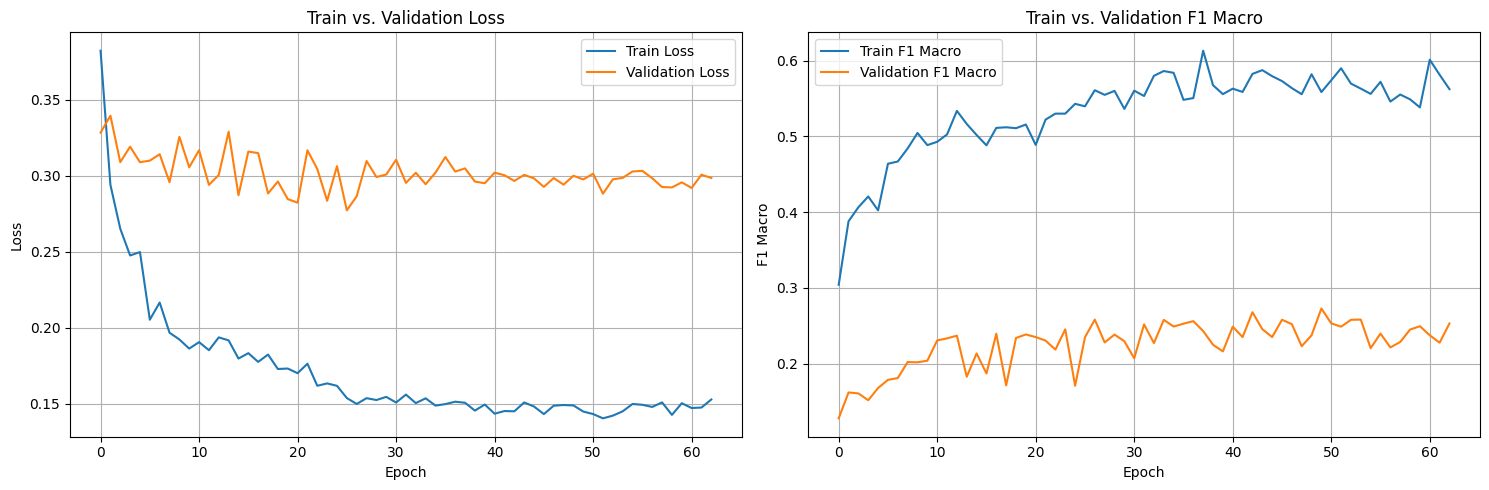

In [23]:
# Load the CSV file
metrics_df = pd.read_csv("/kaggle/working/logs/exp_20260216_135441/version_0/metrics.csv")
metrics_df_ = metrics_df.dropna(how='all') # Drop rows where all values are NaN
metrics_df_ = metrics_df_.ffill() # Forward-fill NaN values (carry last valid observation forward)
metrics_df_ = metrics_df_.groupby('epoch').last().reset_index()

# plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(metrics_df_["epoch"], metrics_df_["train_loss"], label="Train Loss")
axes[0].plot(metrics_df_["epoch"], metrics_df_["val_loss"], label="Validation Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Train vs. Validation Loss")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(metrics_df_["epoch"], metrics_df_["train_f1_macro"], label="Train F1 Macro")
axes[1].plot(metrics_df_["epoch"], metrics_df_["val_f1_macro"], label="Validation F1 Macro")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("F1 Macro")
axes[1].set_title("Train vs. Validation F1 Macro")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### Prediction

In [24]:
# prediction
path = '/kaggle/input/beyond-visible-spectrum-ai-for-agriculture-2026p2/ICPR02/kaggle/evaluation'

test_dataset = S2Dataset(root_dir=path, bands=bands, class_idx=class_idx, labeled=False, transform=val_transform)

# sanity check
print(test_dataset.__len__())
img, img_id = test_dataset.__getitem__(0)
print(f"Shape: {img.shape}")

40
Shape: torch.Size([13, 224, 224])


In [26]:
checkpoint_dir = "/kaggle/working/checkpoints/final_tuned_"
print(os.listdir(checkpoint_dir))

['last.ckpt', 'moco-epoch=049-val_f1_macro=0.2727.ckpt']


In [29]:
# Load the trained model
checkpoint_path = "/kaggle/working/checkpoints/final_tuned_/moco-epoch=049-val_f1_macro=0.2727.ckpt"
model = MoCoClassifier.load_from_checkpoint(checkpoint_path)
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Define class names using your class_idx
class_names = {v: k for k, v in class_idx.items()}  # Reverse class_idx to map indices to names

# Create the test DataLoader
test_loader = DataLoader(test_dataset,batch_size=16,shuffle=False,num_workers=4,
                        worker_init_fn=lambda worker_id: np.random.seed(seed + worker_id))

# predictions
image_ids = []
predictions = []

with torch.no_grad():
    for batch in test_loader:
        imgs, img_ids = batch  # img_ids are the folder names
        imgs = imgs.to("cuda" if torch.cuda.is_available() else "cpu")
        # Get model predictions
        logits = model(imgs)
        preds = logits.argmax(dim=1).cpu().numpy()
        image_ids.extend(img_ids)
        predictions.extend(preds)

# Map predictions to class names
predicted_classes = [class_names[pred] for pred in predictions]

# Save to CSV
results_df = pd.DataFrame({
    "Id": image_ids,
    "Category": predicted_classes
})

results_df.to_csv("/kaggle/working/submission_full_v2.csv", index=False)
results_df.head(5)

Loading custom MoCo checkpoint: /kaggle/input/models/ethelogallo/ssl-full/pytorch/default/1/ssl_backbone_20260215_172951.pth
Detected input channels: 13
Missing keys: 2
Unexpected keys: 0


,Id,Category
0,05835a9764364429b5ac3e11b052649d,Aphid
1,13739e32e7a84f669e6ef1284715e93b,Blast
2,1a419acc1ecc467897d5477a47353fa8,Blast
3,2fb5f497ae1b4b1eb7e8d7ced143aa46,Rust
4,310283f25b5f4b038114acbb6d61a357,Rust


save

In [30]:
import shutil

shutil.make_archive("/kaggle/working/check_full_v2", 'zip', "/kaggle/working/checkpoints/final_tuned_")
shutil.make_archive("/kaggle/working/logs_full_v2", 'zip', "/kaggle/working/logs/exp_20260216_135441")

'/kaggle/working/logs_full_v2.zip'